In [1]:
import os
from utils.extras import get_class_num_list, str2bool
import yaml
import argparse
import torch
from utils.models import set_model, set_classifier, MyLinear, save_test_scores, save_best_model  # , save_head_weights
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.logger import set_logger
from testing import validate, load_model
from testing import calculate_scores
from utils.datasets.dataset_utils import NUM_CLASSES_DICT
from utils.prompt import set_prompt
import copy
from utils.losses import set_loss
import torch.nn.functional as F
import random
import cv2
from utils.dataloader import get_ul_dataloader
from utils.training import set_training_seed, train_probing, run_zeroshot, train_ce, train_flyp
from utils.dataloader import extract_train_dataloader, extract_dataloader, set_dataloaders, set_text_dataloader
from utils.optimizers import set_optimizer, set_params
from active_learning.pcb import PCB
from active_learning.badge import BADGE
from active_learning.coreset import Coreset
from active_learning.entropy import Entropy
from active_learning.ALFA_mix import ALFAMix
from active_learning.LoGo import LoGo
from active_learning.TFS import TFS

In [2]:
def tuning(args, logger, model, preprocess, tokenized_text_prompts):
    # dataloaders
    train_loader, val_loader, test_loader, train_dataset = set_dataloaders(args, model, tokenized_text_prompts, preprocess, logger)
    text_dataloader = set_text_dataloader(args, logger, prompt_tensors,
                                          prompt_tensors_dict) if args.method == 'CMLP' else None
    test_loader_copy = copy.deepcopy(test_loader)

    loss = set_loss(args)
    params, logit_scale = set_params(args, model, classifier_head, logger)  # depend on method
    optimizer, scheduler, total_iter = set_optimizer(args, params, train_loader)

    args.loss = loss
    args.logit_scale = logit_scale
    args.optimizer = optimizer
    args.scheduler = scheduler

    # check zeroshot acc
    if args.check_zeroshot or args.method == 'zeroshot':
        logger.info(f"Check Zero-shot Acc ......")
        run_zeroshot(args, test_loader, model, logger, loss, logit_scale, classifier_head)
    if args.zeroshot_only or args.method == 'zeroshot':
        exit()

    # ---------- Training
    if args.method == 'probing':
        best_model, best_head, best_records, \
            best_logit_scale, val_loader, test_loader = train_probing(args, logger, loss_logger, model, classifier_head, \
                                                                      train_loader, val_loader, test_loader)

    elif args.method == 'finetune':
        best_model, best_head, \
            best_records, best_logit_scale = train_ce(args, logger, loss_logger, model, classifier_head, \
                                                      train_loader, val_loader, test_loader)

    elif args.method == 'FLYP':
        best_model, best_head, best_records, best_logit_scale = train_flyp(args, logger, loss_logger, model, tokenizer,
                                                                           train_loader, val_loader, test_loader,
                                                                           text_prompts)

    else:
        raise NotImplementedError(f"Method {args.method} not implemented.")

    if args.method == 'dataset-cls':
        exit()

    # print the logit_scale
    logger.info(f"logit_scale: {round(logit_scale.item(), 8)}")
    logger.info(f"best_logit_scale: {round(best_logit_scale.item(), 8)}")

    return test_loader_copy, best_model, train_loader, best_logit_scale, best_head, train_dataset

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--log_mode', type=str, default='both', choices=['console', 'file', 'both'], help='where to log.')
parser.add_argument('--folder', type=str, default='output', help='Folder for saving output.')
parser.add_argument('--prefix', type=str, default=None, help='Prefix for Log file Name.')

# model
parser.add_argument('--model_cfg', type=str, default='vitb32_openclip_laion400m', 
                        choices=['vitb32_openclip_laion400m', 'vitb16_openclip_laion400m',
                                 'vitb32_openclip_laion2b', 'rn50_openclip_openai',
                                 'vitb32_clip', 'vitb16_clip', 'rn50_clip', 'rn101_clip'
                                 ],
                        help='ViT Transformer arch.')
# parser.add_argument('--resume_path', type=str, help='Model path to resume training for.')
parser.add_argument('--model_path', default=None, type=str, help='Model path to start training from.')    

# prompt
parser.add_argument('--prompt_name', type=str, default='most_common_name',
                        choices=['most_common_name', 'most_common_name_REAL', 'name', 'name-80prompts',
                                 'c-name', 's-name', 't-name', 'f-name', 'c-name-80prompts'], help='names for prompts.')
parser.add_argument('--use_attribute', default=False, type=str2bool, help='Use attribute when making prompts.')

# dataset
parser.add_argument('--dataset', type=str, default='semi_aves', 
                        choices=['semi_aves', 'aircraft', 'stanford_cars', 'food101', 'oxford_pets'], 
                        help='Dataset name.')
    
# retrieval
parser.add_argument('--database', type=str, default='LAION400M', help='Database from which images are mined.')

# training data
parser.add_argument('--round', default=0, help='AL round')
parser.add_argument('--val_split', type=str, default='fewshotX.txt', help='val file name.')
parser.add_argument('--test_split', type=str, default='test.txt', help='test file name.')
parser.add_argument('--seed', default=888, help='Random seeds for different splits.')
parser.add_argument('--training_seed', type=int, default=888, help='Random seeds for training.')

# training
parser.add_argument('--method', type=str, default='FLYP', choices=['zeroshot','probing', 'finetune', 'FLYP'], 
                        help='Method for training.')
parser.add_argument('--cls_init', type=str, default='text', choices=['random', 'text', 'REAL-Prompt', 'REAL-Linear'], 
                        help='Initialize the classifier head in different ways.')

parser.add_argument('--pre_extracted', default=False, type=str2bool, help='use pre-extracted features.')
parser.add_argument('--freeze_visual', default=False, type=str2bool, help='Freeze the visual encoder during training.')

parser.add_argument('--check_zeroshot', action='store_true', help='check zeroshot acc.')
parser.add_argument('--zeroshot_only', action='store_true', help='run zeroshot only.') 
parser.add_argument('--early_stop', default=False, type=str2bool, help='use val set for early stopping.')    
parser.add_argument('--epochs', type=int, default=50, help='number of epochs to train the model')
parser.add_argument('--stop_epochs', type=int, default=50, help='number of epochs to stop the training of the model')
    
# optimization
parser.add_argument('--num_workers', type=int, default=8, help='Num of workers.') 
parser.add_argument('--start_validation', type=int, default=0, help='Start validation after x iterations.')    
parser.add_argument('--lr_classifier', type=float, default=1e-4, help='Learning rate for the classifier head.')
parser.add_argument('--lr_backbone', type=float, default=1e-6, help='Learning rate for the visual encoder.')
parser.add_argument('--lr_projector', type=float, default=None, help='Learning rate for the visual and text projector.')    
parser.add_argument('--wd', type=float, default=1e-2, help='weight decay for model.')
parser.add_argument('--bsz', type=int, default=32, help='Batch Size')
parser.add_argument('--optim', type=str, default='AdamW', choices=['AdamW', 'SGD'], help='type of optimizer to use.')
parser.add_argument('--temperature', type=float, default=0.07, help='Logit Scale for training')
parser.add_argument('--alpha', type=float, default=0.5, help='mixing ratio for WiSE-FT, alpha=1.0 means no WiSE-FT ensembling.')
parser.add_argument('--ALMETHOD', type=str, default='TFS', help='badge/coreset/entropy/logo/alfa_mix/random/TFS/badge_pcb')

# loss
parser.add_argument('--loss_name', type=str, default='CE', choices=['CE', 'WeightedCE', 'Focal', 'BalancedSoftmax'], help='type of loss function to use.')
parser.add_argument('--dataset_wd', type=float, default=1.0, help='weight decay for dataset classification loss.')

# save
parser.add_argument('--save_ckpt', default=False, type=str2bool, help='Save model checkpoints or not.')
parser.add_argument('--save_freq', type=int, default=10, help='Save Frequency in epoch.')
args = parser.parse_args(args=[])

In [4]:
with open('config.yml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    args.dataset_path = config['dataset_path']
    args.retrieved_path = config['retrieved_path']
if args.cls_init == 'text':
        args.prompt_name = 'name'
args.freeze_visual = False
args.pre_extracted = False
args.val_split = [['val.txt'], [os.path.join(args.dataset_path, args.dataset)]]
args.test_split = [['test.txt'], [os.path.join(args.dataset_path, args.dataset)]]

args.train_split = [[f'{args.ALMETHOD}_{args.method}_seed{args.seed}_round{args.round}.txt'], [os.path.join(args.dataset_path, args.dataset)]]
args.early_stop = True


# adjust folder
args.folder = f'{args.folder}/output_{args.dataset}'

# build cls_num_list
args.dataset_root = f'data/{args.dataset}'
args

Namespace(log_mode='both', folder='output/output_semi_aves', prefix=None, model_cfg='vitb32_openclip_laion400m', model_path=None, prompt_name='name', use_attribute=False, dataset='semi_aves', database='LAION400M', round=0, val_split=[['val.txt'], ['./data/semi_aves']], test_split=[['test.txt'], ['./data/semi_aves']], seed=888, training_seed=888, method='FLYP', cls_init='text', pre_extracted=False, freeze_visual=False, check_zeroshot=False, zeroshot_only=False, early_stop=True, epochs=50, stop_epochs=50, num_workers=8, start_validation=0, lr_classifier=0.0001, lr_backbone=1e-06, lr_projector=None, wd=0.01, bsz=32, optim='AdamW', temperature=0.07, alpha=0.5, ALMETHOD='TFS', loss_name='CE', dataset_wd=1.0, save_ckpt=False, save_freq=10, dataset_path='./data/', retrieved_path='./', train_split=[['TFS_FLYP_seed888_round0.txt'], ['./data/semi_aves']], dataset_root='data/semi_aves')

In [6]:
logger, loss_logger = set_logger(args)
set_training_seed(args)
# load model
model, preprocess, tokenizer = set_model(args, logger)
zeroshot_model = copy.deepcopy(model)
# make prompts
prompt_tensors, text_prompts, tokenized_text_prompts, prompt_tensors_dict = set_prompt(args, model, tokenizer, logger)
# make classifier head
classifier_head = set_classifier(args, prompt_tensors, logger)
zeroshot_head = copy.deepcopy(classifier_head)
classifier_head.to(args.device)

MyLinear(
  (linear): Linear(in_features=512, out_features=200, bias=False)
)

In [8]:
test_loader, best_model, train_loader, best_logit_scale, best_head, train_dataset = tuning(args, logger, model, preprocess, tokenized_text_prompts)

Epoch 1, Iter 397, Trn Loss: 2.425745, Val Loss: 2.765763, Val Acc: 37.4, Val Macro F1: 34.156, Test Acc: 38.138, Test Macro F1: 35.636
Epoch 2, Iter 794, Trn Loss: 1.415932, Val Loss: 2.392658, Val Acc: 44.25, Val Macro F1: 41.992, Test Acc: 44.262, Test Macro F1: 42.644
Epoch 3, Iter 1191, Trn Loss: 1.229764, Val Loss: 2.250009, Val Acc: 46.3, Val Macro F1: 44.574, Test Acc: 47.225, Test Macro F1: 45.845
Epoch 4, Iter 1588, Trn Loss: 1.133559, Val Loss: 2.160406, Val Acc: 48.3, Val Macro F1: 46.735, Test Acc: 49.062, Test Macro F1: 47.664
Epoch 5, Iter 1985, Trn Loss: 1.045223, Val Loss: 2.085168, Val Acc: 49.05, Val Macro F1: 47.654, Test Acc: 49.837, Test Macro F1: 48.702
Epoch 6, Iter 2382, Trn Loss: 0.98825, Val Loss: 2.035001, Val Acc: 50.3, Val Macro F1: 49.034, Test Acc: 50.638, Test Macro F1: 49.475
Epoch 7, Iter 2779, Trn Loss: 0.935466, Val Loss: 2.006655, Val Acc: 50.25, Val Macro F1: 49.008, Test Acc: 50.638, Test Macro F1: 49.475
Epoch 8, Iter 3176, Trn Loss: 0.89273, Va

In [9]:
df = pd.read_csv(loss_logger.name)
df

,Epoch,Iter,Train_loss,Val_loss,Val_acc,Test_acc
0,1,397,2.425745,2.765763,37.40,38.1375
1,2,794,1.415932,2.392658,44.25,44.2625
2,3,1191,1.229764,2.250009,46.30,47.2250
3,4,1588,1.133559,2.160406,48.30,49.0625
4,5,1985,1.045223,2.085168,49.05,49.8375
5,6,2382,0.988250,2.035001,50.30,50.6375
6,7,2779,0.935466,2.006655,50.25,50.6375
7,8,3176,0.892730,1.996506,50.60,51.1000
8,9,3573,0.860758,1.975855,51.20,51.7000
9,10,3970,0.826400,1.981677,50.90,51.7000


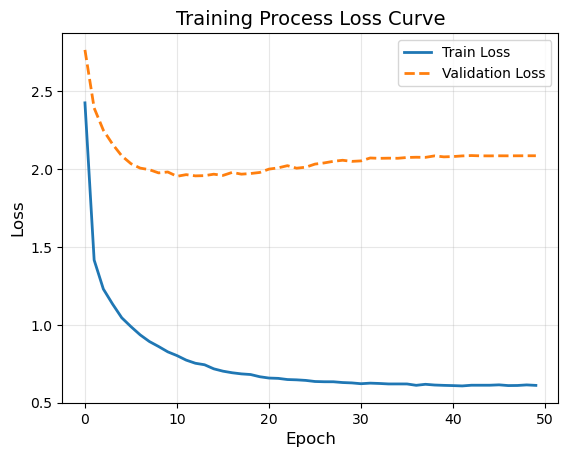

In [10]:
plt.plot(df.Train_loss, 
         label='Train Loss',
         color='#1f77b4',
         linewidth=2)
plt.plot(df.Val_loss,
         label='Validation Loss',
         color='#ff7f0e',
         linestyle='--',
         linewidth=2)
plt.title('Training Process Loss Curve', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

In [11]:
loss = set_loss(args)
with open(f'./data/{args.dataset}/ltrain.txt', 'r') as f:
    all_ul = f.readlines()
n_ul = len(all_ul)
with open(f'./data/{args.dataset}/{args.ALMETHOD}_{args.method}_seed{args.seed}_round{args.round}.txt', 'r') as f:
    labeled = f.readlines()
for i in labeled:
    for j in all_ul:
        if j in i:
            all_ul.remove(j)
with open(f'./data/{args.dataset}/{args.ALMETHOD}_{args.method}_seed{args.seed}_after_round{args.round}.txt', 'w') as f:
    for i in all_ul:
        f.write(i)
ul_file = f'{args.ALMETHOD}_{args.method}_seed{args.seed}_after_round{args.round}.txt'
ul_split = [[ul_file], [os.path.join(args.dataset_path, args.dataset)]]
output_file = f'{args.ALMETHOD}_{args.method}_seed{args.seed}_round{int(args.round) + 1}.txt'
ul_loader = get_ul_dataloader(args, ul_split, tokenized_text_prompts, preprocess)
test_acc, _, test_acc_sk, test_macro_f1_sk, test_length, _, all_dict = validate(args, data_loader=ul_loader,
                                                                            model=best_model, logger=logger,
                                                                            loss=loss, logit_scale=best_logit_scale,
                                                                            classifier_head=best_head,
                                                                            dataset=args.dataset,
                                                                            output_dir=args.output_dir,
                                                                            device=args.device,
                                                                            )

In [12]:
selector = TFS(best_model, ul_loader, best_logit_scale, best_head, len(prompt_tensors), labeled, all_dict, device='cuda')
TFS_idx = selector.select(n_query=len(prompt_tensors))
for i in TFS_idx:
    print(all_ul[i])

| Calculating uncertainty of Unlabeled set
trainval_images/43/6.jpg 43 1

trainval_images/181/6.jpg 181 1

trainval_images/138/1.jpg 138 1

trainval_images/135/11.jpg 135 1

trainval_images/170/0.jpg 170 1

trainval_images/197/5.jpg 197 1

trainval_images/147/4.jpg 147 1

trainval_images/147/6.jpg 147 1

trainval_images/170/3.jpg 170 1

trainval_images/31/10.jpg 31 1

trainval_images/146/5.jpg 146 1

trainval_images/95/8.jpg 95 1

trainval_images/186/7.jpg 186 1

trainval_images/44/27.jpg 44 1

trainval_images/197/4.jpg 197 1

trainval_images/99/13.jpg 99 1

trainval_images/147/11.jpg 147 1

trainval_images/7/21.jpg 7 1

trainval_images/9/19.jpg 9 1

trainval_images/134/11.jpg 134 1

trainval_images/197/1.jpg 197 1

trainval_images/95/11.jpg 95 1

trainval_images/91/8.jpg 91 1

trainval_images/86/16.jpg 86 1

trainval_images/86/4.jpg 86 1

trainval_images/198/0.jpg 198 1

trainval_images/134/2.jpg 134 1

trainval_images/95/3.jpg 95 1

trainval_images/86/6.jpg 86 1

trainval_images/175/

In [13]:
os.remove(f'./data/{args.dataset}/{args.ALMETHOD}_{args.method}_seed{args.seed}_after_round{args.round}.txt')
with open(f'./data/{args.dataset}/{output_file}', 'w') as f:
    for i in labeled:
        f.write(i)
    for i in TFS_idx:
        f.write(all_ul[i])